<h1> <font color='Brick'>Homework 1</font></h1>

# Homework Brief 

You are a business analyst working for a major US toy retailer:

* A manager in the marketing department wants to find out the most frequently used words in positive reviews (five stars) and negative reviews (one star) in order to determine what occasion the toys are purchased for (Christmas, birthdays, and anniversaries.). He would like your opinion on **which gift occasions (Christmas, birthdays, or anniversaries) tend to have the most positive reviews** to focus marketing budget on those days.

* There are malformed characters in the review text. For instance, notice the `&#34;` - these are examples of incorrectly decoded [HTML encodings](https://krypted.com/utilities/html-encoding-reference/).
```
"amazing quality first of all, these cards are amazing proxies (but don't try to use em in &#34;official duels&#34; unless a judge is okay with it, if you have the real thing to show) and look amazing in your binder!"
```
Please clean up all instances of these incorrect decodings.

* One of your product managers suspects that **toys purchased for male recipients (husbands, sons, etc.)** tend to be much more likely to be reviewed poorly. She would like to see some data points confirming or rejecting her hypothesis. 

* Use **regular expressions to parse out all references to recipients and gift occassions**, and account for the possibility that people may spell words "son" / "children" / "Christmas" as both singular and plural, upper or lower-cased.

* Explain what some of **pitfalls/limitations** are of using only a word count analysis to make these inferences. What additional research/steps would you need to do to verify your conclusions? (2-3 sentences, what would you do next)


Perform the same word count analysis using the reviews received from Amazon to answer your marketing manager's question. They are stored in two files, (`poor_amazon_toy_reviews.txt`) and (`good-amazon-toy-reviews.txt`). **Provide a few sentences with your findings and business recommendations.** Make any assumptions you'd like to- this is a fictitious company after all. I just want you to get into the habit of "finishing" your analysis: to avoid delivering technical numbers to a non-technical manager.

**Submit everything as a new notebook and Slack direct message to me (Yu Chen) and the TA the HW as an attachment.**

**NOTE**: Name the notebook `lastname_firstname_HW1.ipynb`.

# Solution


## Importing packages

In [1]:
import pandas as pd
import sys
import re
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import string
from nltk.corpus import stopwords
import seaborn as sns


## Reading in data

In [2]:
# Reading in the positive reviews
goods=pd.DataFrame( open("good_amazon_toy_reviews.txt", "r"), columns=["review"])
goods["review"] = goods["review"].str.replace("\n", "")
goods['type']='Positive'


In [3]:
# Reading in the negative reviews
bads=pd.DataFrame( open("poor_amazon_toy_reviews.txt", "r"), columns=["review"])
bads["review"] = bads["review"].str.replace("\n", "")
bads['type']='Negative'


In [4]:
# Combining both positive and negative reviews into a single DataFrame
reviews=goods.append(bads).reset_index()
reviews.drop(columns=['index'], inplace=True)
reviews.head()

,review,type
0,Excellent!!!,Positive
1,"""Great quality wooden track (better than some ...",Positive
2,my daughter loved it and i liked the price and...,Positive
3,Great item. Pictures pop thru and add detail a...,Positive
4,I was pleased with the product.,Positive


## Finding the most common words in the reviews

In [5]:
# Function to clean the text reviews
def clean_corpus(list):
    new_list=[''.join(c for c in s if c not in string.punctuation) for s in list]
    new_list = [x.replace('\n', '').lower() for x in new_list]
    new_list=[re.sub(r'\b(the|even|up|what|buy|bought|from|there|people|here|after|got|too|because|that|this|have|would|had|if|do|has|like|br|when|is|be|just|can|at|her|him|are|was|were|will|to|it|a|or|and|with|am|i|for|in|on|of|me|my|your|their|them|they|these|as|so|you|very|we|its|one|all|he|she)\b',\
        '', x, flags=re.IGNORECASE) for x in new_list]
    return new_list


In [6]:
# Function to output the most frequently appearing words
def count_words(lines, delimiter=" "): 
    words = Counter() # instantiate a Counter object called words
    for line in lines:
        for word in line.split(delimiter):
            words[word] += 1 # increment count for word
    df=pd.DataFrame(words,columns=['Word','Frequency'])
    df["Word"] = list(words.keys())
    df["Frequency"] = list(words.values())
    df.sort_values(by=['Frequency'],ascending=False, inplace=True)
    return df.loc[1:,:]

In [7]:
negative=clean_corpus(open("poor_amazon_toy_reviews.txt","r").readlines())
positive=clean_corpus(open("good_amazon_toy_reviews.txt","r").readlines())

# Most common words in positive reviews
positive_df=count_words(positive)
top_15_pos=positive_df.head(15)

# Most common words in negative reviews
negative_df=count_words(negative)
top_15_neg=negative_df.head(15)



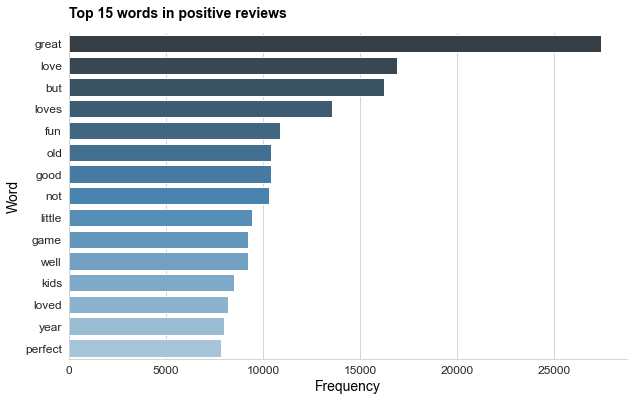

In [8]:
# Plotting top 15 most frequent words in positive review dataset
sns.set_style("whitegrid")
plt.figure(figsize=[10,6])
sns.barplot(y="Word", x="Frequency", data=top_15_pos,palette=("Blues_d"))
plt.title('Top 15 words in positive reviews', loc = 'left',
         fontsize=14, fontweight='bold', color= 'black', 
          pad=15)
plt.ylabel('Word', color= 'black',fontsize=14)
ax=plt.gca()
ax.tick_params(labelsize=12)
plt.xlabel('Frequency', color= 'black',fontsize=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

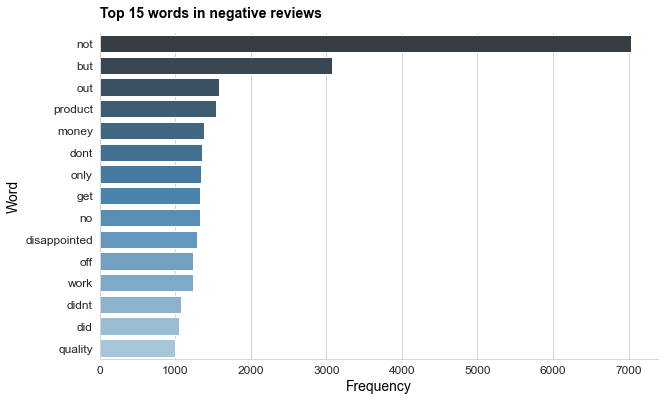

In [9]:
# Plotting top 15 most frequent words in positive review dataset
sns.set_style("whitegrid")
plt.figure(figsize=[10,6])
sns.barplot(y="Word", x="Frequency", data=top_15_neg,palette=("Blues_d"))
plt.title('Top 15 words in negative reviews', loc = 'left',
         fontsize=14, fontweight='bold', color= 'black', 
          pad=15)
plt.ylabel('Word', color= 'black',fontsize=14)
ax=plt.gca()
ax.tick_params(labelsize=12)
plt.xlabel('Frequency', color= 'black',fontsize=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

From the above two graphs, we can see which words are the most frequent among positive and negative reviews. However, here we see that we could greatly benefit from lemmatization techniques to further improve the meaningfulness of this result. 

In general, we see positive reviews have more positive words like:
- great
- fun
- love
- good
- well
- perfect

Negative reviews have more negative intonation words like:
- break
- disappointed
- not, don't, no, didn't
- money
- quality
- work

Since the manager would like to know which occasions produce the most positive reviews, we will explore the answer to his question in the next section.

## Occasions

The objective here is to find out purchases for which occasion contribute the most positive reviews. The manager has defined occasions as Christmas, birthdays and anniversaries so these will be the only occasions considered in this section.


In [10]:
def keyword_flag(name,regex,df):
    # Assuming the column name in the input DataFrame will remain 'review'
    df[f'{name}_keyword']=df['review'].str.findall(regex)
    df[f'{name}_len']=df['review'].str.findall(regex).apply(len)
    mask=df[f'{name}_len']>0
    df[f'{name}_indicator']=np.where(mask,1,0)
    df.drop(columns=[f'{name}_len'],inplace=True)

In [11]:
regex=[r'\b(Christmas|christmas|Xmas|xmas|holiday|holidays)\b',\
       r'\b(birthday|Birthday|bday|b\'day|birthdate|HBD|B\'day|birthdat|special day)\b',\
      r'\b(anniversary|anniversaries|anniv|anniversart)\b']
name=["Christmas","Birthday","Anniversary"]

# Identifying occasions
for n,r in zip(name,regex):
    keyword_flag(n,r,reviews)

In [12]:
# Creating a summary table of reviews for each occasion
occasion_summary= reviews.groupby('type').\
                    agg({'Christmas_indicator':'sum','Birthday_indicator':'sum',\
                    'Anniversary_indicator':'sum'}).T.reset_index()

occasion_summary['Percentage of Positive Reviews']=100*\
round(occasion_summary['Positive']/(occasion_summary['Positive']+occasion_summary['Negative']),4)
occasion_summary.rename(columns={'index':'Occasion'},inplace=True)

In [13]:
occasion_summary

type,Occasion,Negative,Positive,Percentage of Positive Reviews
0,Christmas_indicator,72,1270,94.63
1,Birthday_indicator,430,3895,90.06
2,Anniversary_indicator,4,44,91.67


**From the above table, we can see:**
- Christmas is the occasion that has the maximum **percentage** of positive reviews. However, the total number of reviews (positive and negative) is far less than for birthdays.
- Birthdays have the maximum **number** of positive reviews. However, for marketing purposes, it may be difficult to increase the marketing budget for any particular day.
- Anniversary gifts are relatively far lower than for Christmas or birthdays but this makes sense given that these are reviews for toys and anniversaries are largely celebrated by adults.


**Advice for the Marketing team:**<br><br>
**a. Explore options to analyze birthday information.**
* A new feature could be introduced to add family members or other social features linked to a single account. 
* Another option would be to give users an option to set up reminders for occasions like birthdays and anniversaries where they could get updates from within the app. 
* Track wedding, birthday or other occasion registries that a user visits to make suggestions/ reminders in the future.
* If this disturbs the original business model or violates privacy laws, the team may need to explore other innovative ways for customized targeting or shift its focus away from birthdays.

**b. Christmas**
* Christmas is the next occasion with the most positive reviews. The marketing budget could be increased in the days leading up to the Christmas holiday season to spur an increase in purchases.
* A collaboration with a non-profit like AngelTree which works on providing gifts to children of incarcerated parents could also increase purchases made during the Christmas season. A tie-up like this could cause users who don't usually purchase toys to make their first purchase towards a good cause.

**b. Calendar occasions**
* We could also explore other calendar holidays/occasions like Thanksgiving, Easter, graduation, etc. in the future.

## Cleaning up incorrect decodings

This section removes the html encoding and tags in the dataset.

In [14]:
reviews['review']=reviews['review'].str.replace(r'([&#]\d+[;])',"")
reviews['review']=reviews['review'].str.replace('(<br />)',"")

In [15]:
reviews.to_csv('Cleaned.csv')

In [16]:
assert sum(reviews['review'].str.findall(r'([&#]\d+[;])').apply(len)) == 0,"This error message will be printed if the assertion to the left is not true."

## Male recipient hypothesis

The product manager's hypothesis that toys purchased for male recipients are reviewed more poorly than toys purchased for female recipients. This section analyzes data to evaluate this hypothesis.

In [17]:
# Making a copy of the reviews DataFrame
hyp_df=reviews.copy()
hyp_df.drop(columns=['Christmas_keyword', 'Christmas_indicator',
       'Birthday_keyword', 'Birthday_indicator', 'Anniversary_keyword',
       'Anniversary_indicator'], inplace=True)
hyp_df.head()

,review,type
0,Excellent!!!,Positive
1,"""Great quality wooden track (better than some ...",Positive
2,my daughter loved it and i liked the price and...,Positive
3,Great item. Pictures pop thru and add detail a...,Positive
4,I was pleased with the product.,Positive


In [18]:
# Identifying male and female recipients
recipients=[r'\b(son|sons|boys|boy|husband|hubby|hubs|man of the house|for him|boyfriend|bf|grandpa|grandfather|gramps|grandson|grandsons|brother|brothers|bro|bros|brother-in-law|bro-in-law|nephew|nephews|father|fathers|father-in-law|for [a-z] dad|old man)\b',\
            r'\b(daughter|daughters|girl|girls|wife|wifey|for her|girlfriend|gurlfriend|gf|grandmother|grandma|grammy|sister|sisters|sis|sissy|sister-in-law|sis-in-law|niece|nieces|for [a-z] mom|mother|mothers|for [a-z] mommy)\b']
gender=['Male','Female']
for r,n in zip(recipients,gender):
    keyword_flag(n,r,hyp_df)
hyp_df.head(3)

,review,type,Male_keyword,Male_indicator,Female_keyword,Female_indicator
0,Excellent!!!,Positive,[],0,[],0
1,"""Great quality wooden track (better than some ...",Positive,[],0,[],0
2,my daughter loved it and i liked the price and...,Positive,[],0,[daughter],1


In [19]:
# Creating a summary table
hypothesis_df=hyp_df.groupby('type').agg({'Male_indicator':'sum','Female_indicator':'sum'}).T
hypothesis_df.rename(index={'Male_indicator':'Male','Female_indicator':'Female'}, inplace=True)
hypothesis_df['Total']=hypothesis_df['Positive']+hypothesis_df['Negative']
hypothesis_df['Percentage of Negative Reviews']=100*\
round(hypothesis_df['Negative']/(hypothesis_df['Negative']+hypothesis_df['Positive']),4)
hypothesis_df

type,Negative,Positive,Total,Percentage of Negative Reviews
Male,947,13564,14511,6.53
Female,630,10577,11207,5.62


**From the above table, we can see:**
- The total number of male recipients is greater than female recipients.
- Male recipients **do seem to have a higher percentage of negative reviews.**
- One shortcoming here is that this result was from manually parsing out male and female recipients. Some reviews mention recipients like "children", "5 year old", "cousin", etc. for which it is impossible to infer the gender by this manual parsing method. An AI model may be able to better infer recipient information.

The data in this table offers support to the product manager's hypothesis. Beyond the data in this table, the product manager may benefit from a statistical test to confirm this hypothesis.

## Summary

**Summary of work:**
- In the first section, we parsed all variations out the popular occasions for which toys were purchased. We considered birthdays, anniversaries and Christmas. I did consider "wedding" and its variations as an occasion but the likelihood of purchasing toys for a wedding is relatively low and hence, I did not include other occasions.


- Then, we got rid of the incorrect html encoding and tags in the reviews.


- In the next section, we parsed out the gender of the recipients of the toys using regular expressions (some cases even accounting for misspelled words like "birthdat"). We saw that males were more often recipients of toys than females.

## Pitfalls of word count analysis

1. This method of word count analysis does not factor in **semantic meaning**. There is no way to build in a distinction between "my friend got this for her **dad**" vs. "..her **dad** wouldn't allow her to..". In the first case, "dad" is the recipient but in the second case "dad" is not the recipient of the product.


2. While matching for male and female recipients of the products, a review like "My daughter had this when she was 5. It's now a hand-me-down for my 2 year old son" gets flagged for both the words "son":male and "daughter":female. Word count analysis is not able to identify who the recipient is.


3. It is not possible to infer the gender of words like "cousin", "children", etc. even though the next lines in the review may possibly imply the gender with words like "he" or "she". Word count analysis does not factor this in.


4. Word count analysis does not intuitively count variations of a single word as the same word. For instance "love" and "loves" are the same word but word count analysis counts these are two separate words. Lemmatization of these words would lead to a better solution.
